# Experiment 2 

The goal for Experiment 2 is to build on the VPDDPG model developed in E1 by upgrading the algorithm used to TD3. Additionally we explore the validity of using a Distributional Critic agent to improve performance, creating the TD4 algorithm. 


## Imports


In [107]:
import warnings
warnings.filterwarnings("ignore")

import os 
import pandas as pd
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep
import pyfolio as pf
from pyfolio import timeseries
import copy
%matplotlib inline

from stable_baselines3 import TD3
from sb3_contrib.tqc.tqc import TQC
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from scipy import stats 

sys.path.append("../")
from FunctionFiles.env.EnvMultipleStock_train import StockEnvTrain
from FunctionFiles.env.EnvMultipleStock_validation import StockEnvValidation
from FunctionFiles.env.EnvMultipleStock_trade import StockEnvTrade
from FunctionFiles.pipeline.backtesting_pipeline import position_analysis
from FunctionFiles.pipeline.training_pipeline import training
from FunctionFiles.pipeline.backtesting_pipeline import backtesting, probabilistic_sharpe_ratio
from FunctionFiles.pipeline.backtesting_pipeline import TB_Logs
from Algorithms.VPTD3.VPTD3 import VPTD3
from Algorithms.TD4.TD4 import TD4
from Algorithms.VPTD4.VPTD4 import VPTD4
from FunctionFiles.env.EnvMultipleStock_trade_pca import StockEnvTradePCA
from FunctionFiles.env.EnvMultipleStock_train_pca import StockEnvTrainPCA
sys.path.append("Experiment 2/")

plt.rcParams.update({'font.size': 18})

## Training

In [7]:
def run_training(data, rebalance_window, validation_window, num_of_runs, model_name, training_function, folder_name, train_env, val_env, trade_env, env_wrapper, turbulence_threshold_level, start_point):
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()

    for i in range(start_point, num_of_runs+1):
        tr = training(model_name, train_env, val_env, trade_env, env_wrapper)
        tr.retraining_approach(
            df=data, 
            unique_trade_dates = unique_trade_date,
            rebalance_window = rebalance_window,
            validation_window=validation_window,
            training_instance = f'{folder_name}{i}',
            turbulence_threshold_level = turbulence_threshold_level,
            training_function = training_function, 
        )

In [8]:
class TensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
    
    def _on_step(self) -> bool:
        self.logger.record('Reward', self.locals['env'].env_method(method_name = "get_reward")[0])
        return True

### Base TD3 

This section details the implementation and performance of the TD3 algorithm utilizing the PCA90 state space

In [3]:
def train_TD3(env_train, model_name, training_instance, timesteps = 10000):
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
    save_path = f"trained_models/TD3/{training_instance}"
    if not os.path.isdir(save_path): 
        os.mkdir(save_path)
        os.mkdir(save_path+"/Tensorboard")

    start = time.time()
    model = TD3('MlpPolicy', env_train, action_noise=action_noise, tensorboard_log = save_path+"/Tensorboard", device='cuda', gamma=0.99, batch_size=256, buffer_size=10000)
    model.learn(total_timesteps=timesteps, tb_log_name=f"TB_{model_name.split('_')[-1]}", callback=TensorboardCallback(), log_interval=1)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (TD3): ', (end-start)/60,' minutes')
    return model

In [ ]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

run_training(
    data = data,
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 20,
    model_name = "TD3_DOW", 
    training_function = train_TD3,
    folder_name = "pca90_",
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.9
)

### Volatility Prioritized TD3

Testing the application of the Volatility Prioritized Replay Buffer to the TD3 algorithm utilizing the 90% data retention PCA results from experiment 1

In [38]:
def train_VPTD3(env_train, model_name, training_instance, timesteps = 5000):
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
    save_path = f"trained_models/VPTD3/{training_instance}"
    if not os.path.isdir(save_path): 
        os.mkdir(save_path)
        os.mkdir(save_path+"/Tensorboard")

    start = time.time()
    model = VPTD3('MlpPolicy', env_train, action_noise=action_noise, gamma=0.9999, learning_rate=0.0197, batch_size=32, buffer_size=1000000, tau=0.005, train_freq=1, tensorboard_log = save_path+"/Tensorboard", device='cuda')
    model.learn(total_timesteps=timesteps, tb_log_name=f"TB_{model_name.split('_')[-1]}", callback=TensorboardCallback(), log_interval=1)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (VPTD3): ', (end-start)/60,' minutes')
    return model

In [ ]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

run_training(
    data = data,
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 20,
    model_name = "VPTD3_DOW", 
    training_function = train_VPTD3,
    folder_name = "pca90_",
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.9
)

### Base TD4

TD4 is a variation of TD3 which utilizes distributional reinforcement learning to improve risk aversion performance

In [12]:
def train_TD4(env_train, model_name, training_instance, timesteps = 1000):
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
    save_path = f"trained_models/TD4/{training_instance}"
    if not os.path.isdir(save_path): 
        os.mkdir(save_path)
        os.mkdir(save_path+"/Tensorboard")

    start = time.time()
    model = TD4('DistributionalPolicy', env_train,
                action_noise=action_noise, 
                gamma=0.999, 
                learning_rate=0.17, 
                batch_size=256,
                buffer_size=100000, 
                tau=0.001, 
                train_freq=256, 
                policy_kwargs = {
                    "n_quantiles" : 100,
                    "n_critics" : 2
                },
                tensorboard_log = save_path+"/Tensorboard", device='cuda')
    model.learn(total_timesteps=timesteps, tb_log_name=f"TB_{model_name.split('_')[-1]}", callback=TensorboardCallback(), log_interval=1)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (TD4): ', (end-start)/60,' minutes')
    return model

In [18]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

run_training(
    data =  data,
    rebalance_window = 63, 
    validation_window = 63, 
    start_point = 16,
    num_of_runs = 16,
    model_name = "TD4_DOW", 
    training_function = train_TD4,
    folder_name = "pca90_",
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.9
)

turbulence_threshold:  171.09407156310158
====== TD4_DOW Training========
Training time (TD4):  1.0182947278022767  minutes
======Trading from:  20160104 to  20160405
126
20160104 20160405
Sharpe:  0.2255396976525769
turbulence_threshold:  96.08032158358223
====== TD4_DOW Training========
Training time (TD4):  0.997691011428833  minutes
======Trading from:  20160405 to  20160705
189
20160405 20160705
Sharpe:  -0.004045016677219484
turbulence_threshold:  171.09407156310158
====== TD4_DOW Training========
Training time (TD4):  1.0290503700574238  minutes
======Trading from:  20160705 to  20161003
252
20160705 20161003
Sharpe:  0.152391421034103
turbulence_threshold:  171.09407156310158
====== TD4_DOW Training========
Training time (TD4):  1.0299964149792988  minutes
======Trading from:  20161003 to  20170103
315
20161003 20170103
Sharpe:  0.7152771128318847
turbulence_threshold:  171.09407156310158
====== TD4_DOW Training========
Training time (TD4):  1.0139692982037862  minutes
======Tr

### Volatility Priortized TD4

Testing the application of the Volatility Prioritized Replay Buffer to the TD4 algorithm utilizing the 90% data retention PCA results from experiment 1


In [3]:
def train_VPTD4(env_train, model_name, training_instance, timesteps = 2500):
    n_actions = env_train.action_space.shape[-1]
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.7) * np.ones(n_actions))
    save_path = f"trained_models/VPTD4/{training_instance}"
    if not os.path.isdir(save_path): 
        os.mkdir(save_path)
        os.mkdir(save_path+"/Tensorboard")

    start = time.time()
    model = VPTD4('DistributionalPolicy', env_train,
                action_noise=action_noise, 
                gamma=0.999, 
                learning_rate=0.17, 
                batch_size=512,
                buffer_size=100000, 
                tau=0.001, 
                train_freq=256, 
                top_quantiles_to_drop_per_net = 4,
                policy_kwargs = {
                    "n_quantiles" : 80,
                    "n_critics" : 2
                },
                tensorboard_log = save_path+"/Tensorboard", device='cuda')
    model.learn(total_timesteps=timesteps, tb_log_name=f"TB_{model_name.split('_')[-1]}", callback=TensorboardCallback(), log_interval=1)
    end = time.time()

    model.save(f"{save_path}/{model_name}")
    print('Training time (VPTD4): ', (end-start)/60,' minutes')

    return model

In [4]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

In [ ]:
run_training(
    data = data,
    rebalance_window = 63, 
    validation_window = 63, 
    num_of_runs = 15,
    start_point = 15,
    model_name = "VPTD4_DOW", 
    training_function = train_VPTD4,
    folder_name = "pca90_",
    train_env = StockEnvTrainPCA, 
    val_env = StockEnvValidation,
    trade_env = StockEnvTradePCA,
    env_wrapper = DummyVecEnv,
    turbulence_threshold_level = 0.9, 
)


## Testing 

In [3]:
print('TD3')
td3 = backtesting(
    model_name = [
        "TD3_DOW_pca90_1", "TD3_DOW_pca90_2", "TD3_DOW_pca90_3", "TD3_DOW_pca90_4", "TD3_DOW_pca90_5", 
        "TD3_DOW_pca90_6", "TD3_DOW_pca90_7", "TD3_DOW_pca90_8", "TD3_DOW_pca90_9", "TD3_DOW_pca90_10", 
        "TD3_DOW_pca90_11", "TD3_DOW_pca90_12", "TD3_DOW_pca90_13", "TD3_DOW_Base_10k_14", "TD3_DOW_pca90_15",
        "TD3_DOW_pca90_16", "TD3_DOW_pca90_17", "TD3_DOW_pca90_18", "TD3_DOW_Base_10k_19", "TD3_DOW_pca90_20"
    ],

)

print('\nVPTD3')
vptd3 = backtesting(
    model_name = [
        "VPTD3_DOW_pca90_1", "VPTD3_DOW_pca90_2", "VPTD3_DOW_pca90_3", "VPTD3_DOW_pca90_4", "VPTD3_DOW_pca90_5", 
        "VPTD3_DOW_pca90_6", "VPTD3_DOW_pca90_7", "VPTD3_DOW_pca90_8", "VPTD3_DOW_pca90_9", "VPTD3_DOW_pca90_10", 
        "VPTD3_DOW_pca90_11", "VPTD3_DOW_pca90_12", "VPTD3_DOW_pca90_13", "VPTD3_DOW_Base_10k_14", "VPTD3_DOW_pca90_15",
        "VPTD3_DOW_pca90_16", "VPTD3_DOW_pca90_17", "VPTD3_DOW_pca90_18", "VPTD3_DOW_Base_10k_19", "VPTD3_DOW_pca90_20"
    ],
)

print('\nTD4 Testing')
td4 = backtesting(
    model_name = [
        "TD4_DOW_test_1", "TD4_DOW_test_2", "TD4_DOW_test_3", "TD4_DOW_test_4", "TD4_DOW_test_5",
        "TD4_DOW_test_6", "TD4_DOW_test_7", "TD4_DOW_test_8", "TD4_DOW_test_9", "TD4_DOW_test_10",
        "TD4_DOW_test_11", "TD4_DOW_test_12", "TD4_DOW_test_13", "TD4_DOW_test_14", "TD4_DOW_test_15",
        "TD4_DOW_test_16", "TD4_DOW_test_17", "TD4_DOW_test_18", "TD4_DOW_test_19", "TD4_DOW_test_20"
    ],
)

print('\nVPTD4 Testing')
vptd4 = backtesting(
    model_name = [
        "VPTD4_DOW_pca90_1", "VPTD4_DOW_pca90_2", "VPTD4_DOW_pca90_3", "VPTD4_DOW_pca90_4", "VPTD4_DOW_pca90_5",
        "VPTD4_DOW_pca90_6", "VPTD4_DOW_pca90_7", "VPTD4_DOW_pca90_8", "VPTD4_DOW_pca90_9", "VPTD4_DOW_pca90_10",
        "VPTD4_DOW_pca90_11", "VPTD4_DOW_pca90_12", "VPTD4_DOW_pca90_13", "VPTD4_DOW_pca90_14", "VPTD4_DOW_pca90_15",
        "VPTD4_DOW_pca90_16", "VPTD4_DOW_pca90_17", "VPTD4_DOW_pca90_18", "VPTD4_DOW_pca90_19", "VPTD4_DOW_pca90_20",
    ],
)

TD3
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.114471    0.110935
Cumulative Return   0.631421    0.605459
Annual Volatility   0.0839395   0.0844997
Sharpe Ratio        1.33595     1.33308
Sortino Ratio       2.06733     2.07385
Max Drawdown       -0.066804   -0.0651637
Sharpe STD: 0.19553917607535173

VPTD3
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.125789    0.122542
Cumulative Return   0.705259    0.682334
Annual Volatility   0.0845271   0.0837762
Sharpe Ratio        1.44695     1.42303
Sortino Ratio       2.25062     2.21408
Max Drawdown       -0.0697011  -0.067805
Sharpe STD: 0.102279203294417

TD4 Testing
Attribute                Mean      Median
-----------------  ----------  ----------
Annual Return       0.117542    0.113757
Cumulative Return   0.650752    0.623899
Annual Volatility   0.0829921   0.0835425
Sharpe Ratio        1.38088     1.33577
Sortino

### Wil Coxon Results

In [8]:
p_value = stats.wilcoxon(td3.avg_agent.sharpe, vptd4.avg_agent.sharpe, alternative='less').pvalue
print(f"P-Value: {round(p_value, 5)}, %: {round(p_value*100, 2)}")

P-Value: 0.00158, %: 0.16


## Graphing

In [4]:
def min_max_performance_graph(algorithm_data, mid_run_index, title):
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))
    ax1.grid()
    ax1.set_title(title)

    min_data = algorithm_data.avg_agent.account_value[np.where(algorithm_data.avg_agent.sharpe == algorithm_data.avg_agent.sharpe.min())[0][0]]
    max_data = algorithm_data.avg_agent.account_value[np.where(algorithm_data.avg_agent.sharpe == algorithm_data.avg_agent.sharpe.max())[0][0]]
    mid_data = algorithm_data.avg_agent.account_value[mid_run_index]

    x = pd.to_datetime(min_data.dropna().Date)
    y_max = max_data.dropna().account_value
    y_min = min_data.dropna().account_value
    y_mid = mid_data.dropna().account_value
    ax1.plot(x, y_min, label = 'Min Account Value')
    ax1.plot(x, y_max, label = 'Max Account Value')
    ax1.plot(x, y_mid, label = 'Median Account Value', color = "purple")
    ax1.fill_between(x, y_min, y_max, color='green', alpha=0.2)

    dji = pd.read_csv("../data/^DJI.csv")
    test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-07-06')]
    test_dji = test_dji.reset_index(drop=True)
    test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)
    test_dji["cum_returns"] = ep.cum_returns(test_dji.daily_return, 1.0)*1000000
    ax1.plot(pd.to_datetime(test_dji.Date), test_dji.cum_returns, label = "DJIA Account Value", color="Black")

    ax1.legend()
    plt.show()

def _get_account_value_retraining(model_name, rebalance_window, validation_window, unique_trade_date):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv(f'working_files/account_value_trade_{i}_{model_name}.csv')
        df_account_value = pd.concat([df_account_value, temp])
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    df_account_value = df_account_value.reset_index(drop=True)
    df_account_value=df_account_value.join(pd.DataFrame({'datadate':unique_trade_date})[63:].reset_index(drop=True))
    df_account_value['daily_return']=df_account_value.account_value.pct_change(1)
    return df_account_value

def return_graphs(input_data1, input_data2, input_data3, input_data4):
    fig = plt.figure(1)

    ax1 = plt.subplot(2,2,1)
    pf.plot_monthly_returns_dist(input_data1)
    ax1.title.set_text('DJIA')

    ax2 = plt.subplot(2,2,2)
    pf.plot_monthly_returns_dist(input_data2)
    ax2.title.set_text('TD4')

    ax3 = plt.subplot(2,2,3)
    pf.plot_monthly_returns_dist(input_data3)
    ax3.title.set_text('VP-TD3')

    ax4 = plt.subplot(2,2,4)
    pf.plot_monthly_returns_dist(input_data4)
    ax4.title.set_text('VP-TD4')
    
    plt.tight_layout()
    fig.set_size_inches(10,10)
    fig.tight_layout() 

    plt.show()

In [7]:
preprocessed_path = "../Data/done_data_pca90.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

dji = pd.read_csv("../data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-07-06')]
test_dji = test_dji.reset_index(drop=True)
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

strategy_ret= test_dji.copy()
strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
strategy_ret.set_index('Date', drop = False, inplace = True)
strategy_ret.index = strategy_ret.index.tz_localize('UTC')
del strategy_ret['Date']
ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)

perf_stats_all = timeseries.perf_stats(
    returns=ts,
    positions=None,
    transactions=None,
    turnover_denom="AGB",
)

In [ ]:
min_max_performance_graph(vptd4, 6, "Return Distribution for VP-TD4 Algorithm")
min_max_performance_graph(td4, 6, "Return Distribution for TD4 Algorithm")
min_max_performance_graph(td3, 6, "Return Distribution for TD3 Algorithm")

In [ ]:
unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()
ad = _get_account_value_retraining("VPTD3_DOW_pca90_6", 63, 63, unique_trade_date)
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
vptd3_res = pd.Series(ad['daily_return'].values, index=ad.index)

ad = _get_account_value_retraining("VPTD4_DOW_pca90_6", 63, 63, unique_trade_date)
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
vptd4_res = pd.Series(ad['daily_return'].values, index=ad.index)

ad = _get_account_value_retraining("TD4_DOW_pca90_5", 63, 63, unique_trade_date)
ad['Date'] = pd.to_datetime(ad['datadate'], format = "%Y%m%d")
ad.set_index('Date', drop = True, inplace = True)
ad.index = ad.index.tz_localize('UTC')
td4_res = pd.Series(ad['daily_return'].values, index=ad.index)

plt.rcParams.update({'font.size': 15})
return_graphs(ts, td4_res, vptd3_res, vptd4_res) 

In [59]:
best_iter_td3 = np.where(td3.avg_agent.sharpe == td3.avg_agent.sharpe.max())[0][0]
best_iter_vptd3 = np.where(vptd3.avg_agent.sharpe == vptd3.avg_agent.sharpe.max())[0][0]
best_iter_td4 = np.where(td4.avg_agent.sharpe == td4.avg_agent.sharpe.max())[0][0]
best_iter_vptd4 = np.where(vptd4.avg_agent.sharpe == vptd4.avg_agent.sharpe.max())[0][0]

x_td3 = position_analysis(
    model_name = "TD3_DOW", 
    folder_name = "pca90_", 
    iter = best_iter_td3
)
x_td3.load_action_data()

x_vptd3 = position_analysis(
    model_name = "VPTD3_DOW", 
    folder_name = "pca90_", 
    iter = best_iter_vptd3
)
x_vptd3.load_action_data()

x_td4 = position_analysis(
    model_name = "TD4_DOW", 
    folder_name = "pca90_", 
    iter = best_iter_td4
)
x_td4.load_action_data()

x_vptd4 = position_analysis(
    model_name = "VPTD4_DOW", 
    folder_name = "pca90_", 
    iter = best_iter_vptd4
)
x_vptd4.load_action_data()

In [ ]:
plt.rcParams.update({'font.size': 20})

def compare_models(mod1, mod2, symbol, mod1_name, mod2_name, tics):
    # plt.tight_layout()
    fig, ax = plt.subplots(figsize=(25, 10), layout='constrained')
    fig.suptitle(f'Position Movements vs Asset Price for {symbol}')

    prices = data[(data.datadate.isin(mod1.dates_list))&(data.tic == symbol)].adjcp.tolist()

    ax.grid()
    ax1 = ax.twinx()
    ax.plot([0] + mod1.actions_df[str(tics.index(symbol))].tolist(), label=f'Assets Held ({mod1_name})', zorder=10, color="blue", linewidth=2.0)
    ax.plot([0] + mod2.actions_df[str(tics.index(symbol))].tolist(), label=f'Assets Held ({mod2_name})', zorder=10, color="green", linewidth=2.0)
    ax1.plot(prices, color="purple", label="Asset Price", linewidth=3.0)

    handles, labels = ax.get_legend_handles_labels()   
    handles2, labels2 = ax1.get_legend_handles_labels()   
    by_label = dict(zip(labels2+labels, handles2+handles)) 
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08))

    plt.savefig(f"../Report/content/Chapters/05_Evaluation/figures/TD3vsTD4_{symbol}", bbox_inches='tight')

preprocessed_path = "../Data/done_data.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)

tics = data.tic[:30].tolist()
for t in tics:
    compare_models(x_td3, x_td4, t, "TD3", "TD4", tics)

1116

In [223]:
def sector_split(model, tics):
    volume_usd = model.actions_df.copy()
    sector_index = {
        "Financial Services" : ["1", "8", "13", "23", "25"],
        "Healthcare" : ["12", "17", "20", "24", "27"],
        "Technology" : ["0", "4", "10", "11", "18"],
        "Industrials" : ["2", "3", "16", "22"],
        "Energy" : ["5", "29"],
        "Basic Materials" : ["6"],
        "Communication Services" : ["7", "26"],
        "Consumer Cyclical" : ["9", "15", "19"],
        "Consumer Defensive" : ["14", "21", "28"]
    }
    dates = data[(data.datadate.isin(x_td3.dates_list))]["datadate"].unique().tolist()

    counter = 0
    for t in tics:
        prices = data[(data.datadate.isin(model.dates_list))&(data.tic == t)].adjcp.tolist()
        volume_usd[str(counter)] = volume_usd[str(counter)]*prices
        counter += 1
    
    sector_df = pd.DataFrame(columns=["Financial Services", "Healthcare", "Technology", "Industrials", "Energy", "Basic Materials", "Communication Services", "Consumer Cyclical", "Consumer Defensive"])
    for key in sector_index.keys():
        sector_df[key] = volume_usd[sector_index[key]].sum(axis=1)
    sector_df["date"] = dates
    
    return sector_df

def pie_vol(title, date_code, data):
    fig, ax = plt.subplots(figsize=(10, 10), layout='constrained')
    ax.set_title(title)

    pie_data = data[data.date == date_code]
    pie_data = pie_data[["Financial Services", "Healthcare", "Technology", "Industrials", "Energy", "Basic Materials", "Communication Services", "Consumer Cyclical", "Consumer Defensive"]]
    ax.pie(pie_data.values.flatten().tolist(), labels = pie_data.columns.tolist(), autopct='%1.1f%%')

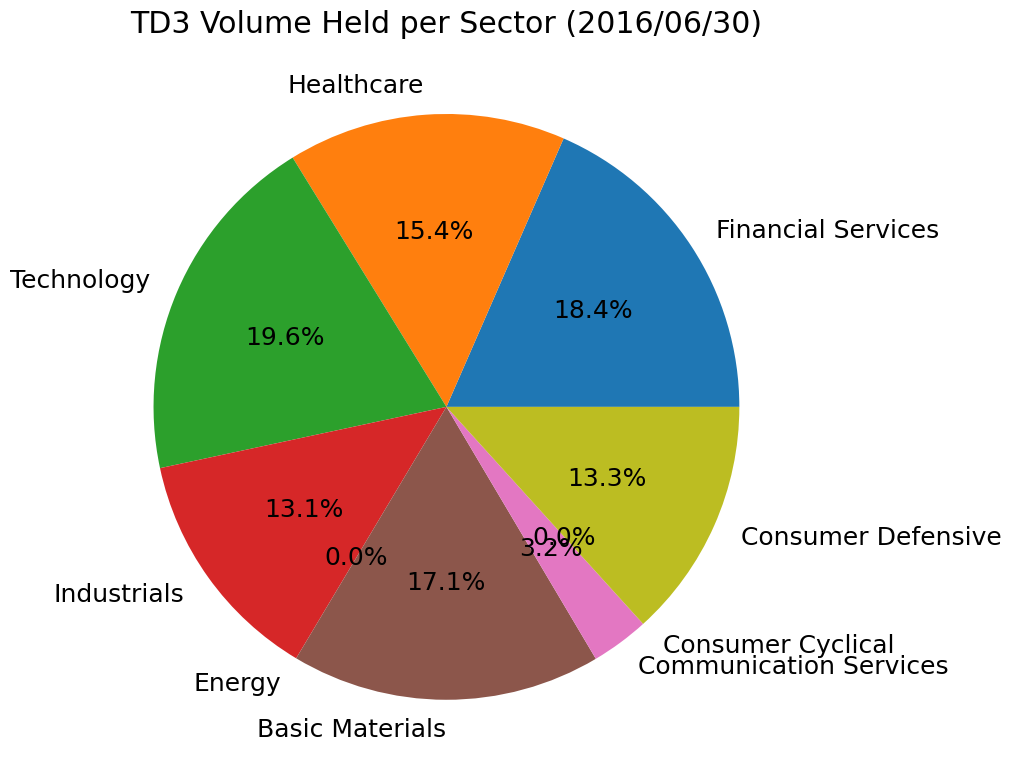

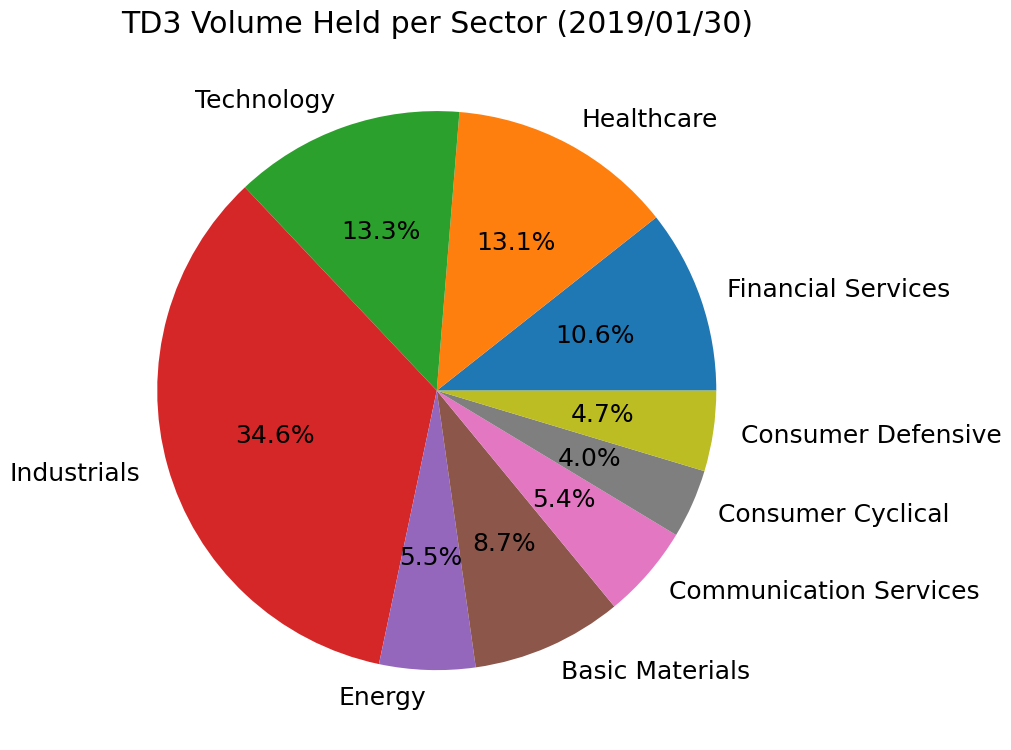

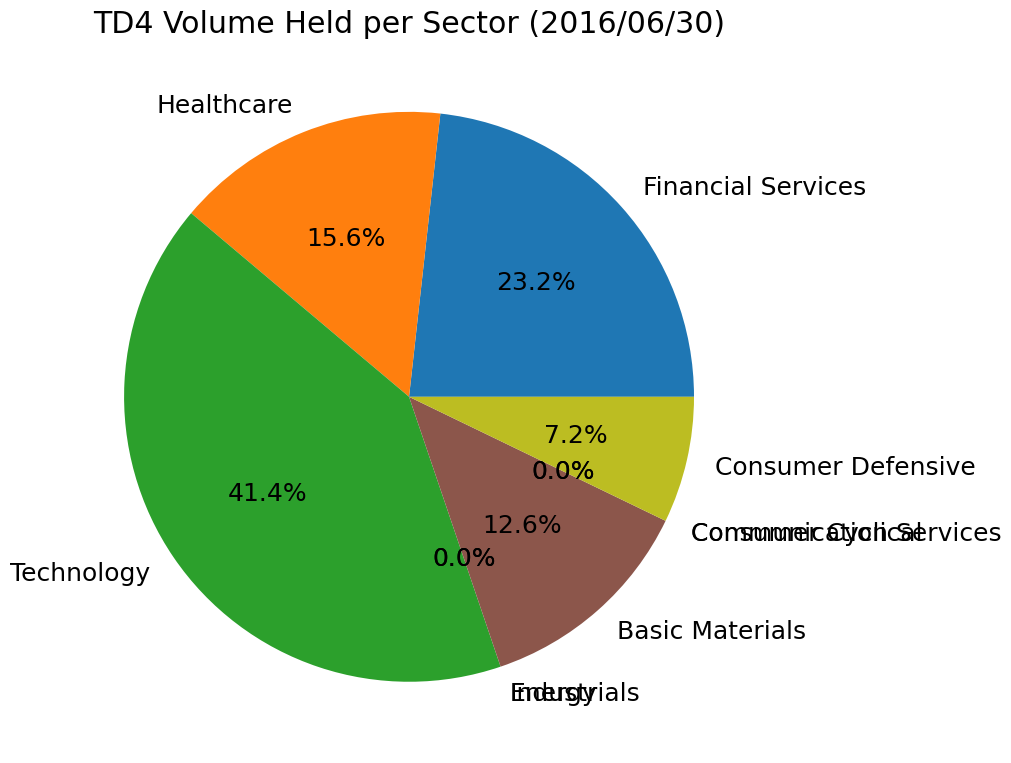

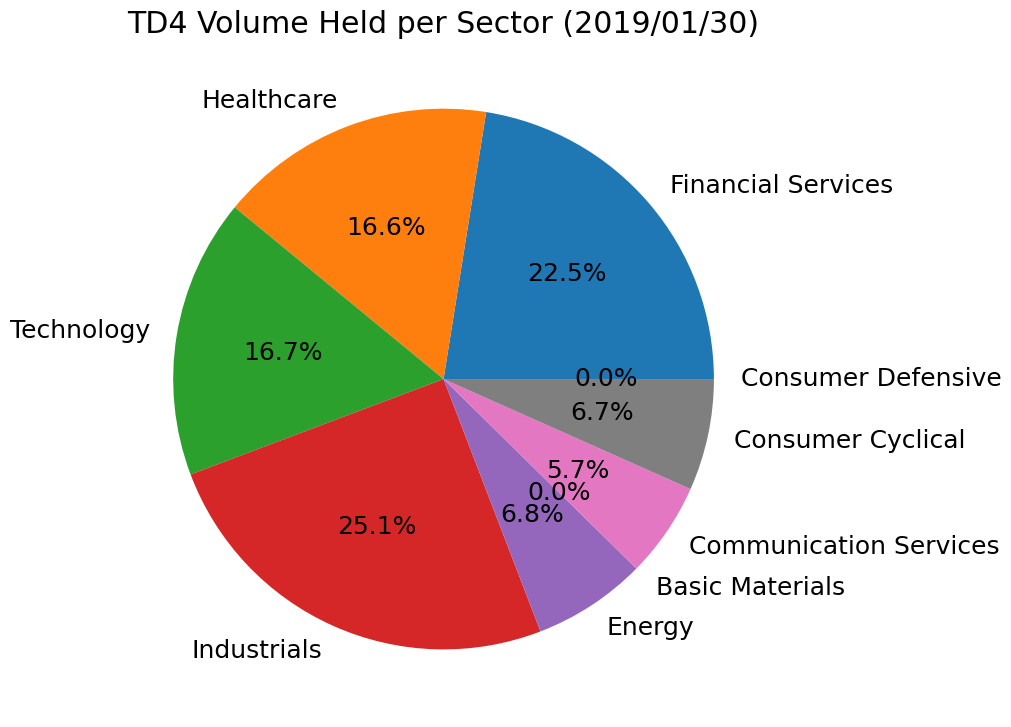

In [238]:
td3_sector_data = sector_split(x_td3, tics)
pie_vol("TD3 Volume Held per Sector (2016/06/30)", 20160630, td3_sector_data)
pie_vol("TD3 Volume Held per Sector (2019/01/30)", 20190130, td3_sector_data)

td4_sector_data = sector_split(x_td4, tics)
pie_vol("TD4 Volume Held per Sector (2016/06/30)", 20160630, td4_sector_data)
pie_vol("TD4 Volume Held per Sector (2019/01/30)", 20190130, td4_sector_data)
